# System Simulation using Simpy

`$ pip install seaborn simpy faker`

## Números aleatorios

In [1]:
import random
mean = 5.4
numeros = [random.expovariate(1.0 / mean) for i in range(0, 10000)]
numeros[:3]

[0.5665777090395991, 21.645654370195658, 13.750577629468491]

Media: 5.469922


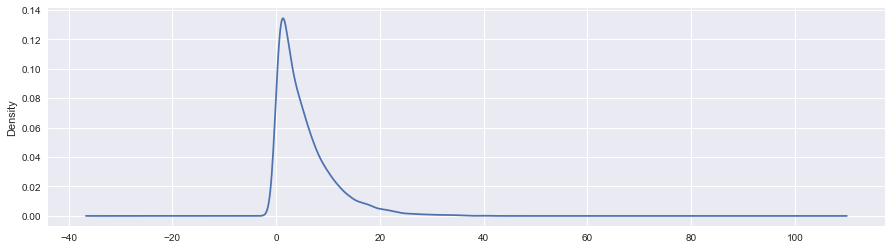

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series

s = Series(numeros)
print("Media: %f" % s.mean())
s.plot.density(figsize=(15,4))

In [3]:
from numpy import random as nprnd
numeros = nprnd.exponential(mean, 10000)
s = Series(numeros)
print("Media: %f" % s.mean())

Media: 5.320677


## Strings aleatorios

In [5]:
from faker import Factory
fake = Factory.create('es-ES')
print(fake.name())
print(fake.address())

Belen del Rebollo
Callejón de Patricia Bermejo 4
Cáceres, 28928


## Ley de Little

$L = \lambda \cdot W$

Siendo $L$ el número medio de clientes, $\lambda$ la tasa de llegadas y $W$ el tiempo medio de espera en el sistema.

*Ejemplo*: ¿Cuántos clientes debería haber en el sistema si llegan 10 por hora y de media esperan 1.5 minutos?

$L = \lambda \cdot W = 10 \cdot 1.5 = 15$

*Ejemplo*: calcular el tiempo medio en el sistema para una cola con 15 clientes y una tasa de llegadas de 10 clientes por minuto.

$W = \frac{L}{\lambda} = \frac{15}{10} = 1.5 {min.}$

## Simulación cola básica M/M/1

 0.0000 Adrián se pone en cola
 0.0000 Adrián ha esperado 0.000000
 0.1266 Adrián servido en 0.126644
 3.0602 Juan Manuel se pone en cola
 3.0602 Juan Manuel ha esperado 0.000000
 4.0251 Alba se pone en cola
 4.3231 Juan Manuel servido en 1.262931
 4.3231 Alba ha esperado 0.298059
 8.0258 Milagros se pone en cola
 9.9690 Alba servido en 5.645865
 9.9690 Milagros ha esperado 1.943146
10.4237 Milagros servido en 0.454762
14.7077 Juan Francisco se pone en cola
14.7077 Juan Francisco ha esperado 0.000000
14.8589 Juan Francisco servido en 0.151251
16.3518 Marcos se pone en cola
16.3518 Marcos ha esperado 0.000000
17.0920 Silvia se pone en cola
17.1727 Julio se pone en cola
17.8377 Marcos se pone en cola
19.8714 Marcos servido en 3.519578
19.8714 Silvia ha esperado 2.779428
20.9862 Silvia se pone en cola
23.8081 Silvia servido en 3.936646
23.8081 Julio ha esperado 6.635391
28.2571 Julio servido en 4.449044
28.2571 Marcos ha esperado 10.419359
36.5458 Marcos servido en 8.288690
36.5458 Silvia

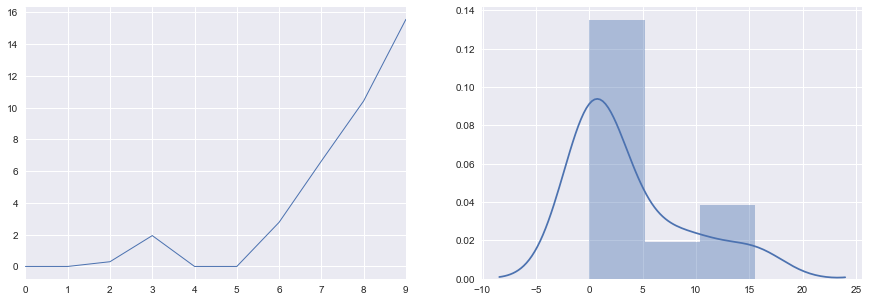

In [6]:
import warnings
warnings.filterwarnings('ignore')

import simpy

t_espera = []
t_servicio = []

log = print
# log = lambda s: 0

def source(env, number, intervalo_llegadas, cola, tiempo_sistema):
    for i in range(number):
        c = cliente(env, fake.first_name(), cola, tiempo_sistema)
        env.process(c)
        t = random.expovariate(1.0 / intervalo_llegadas)
        yield env.timeout(t)

def cliente(env, nombre, cola, tiempo_sistema):
    llegada = env.now
    log('%7.4f %s se pone en cola' % (llegada, nombre))

    with cola.request() as req:        
        yield req
        
        espera = env.now - llegada
        t_espera.append(espera)
        log('%7.4f %s ha esperado %f' % (env.now, nombre, espera))
        
        inicio_servicio = env.now
        tiempo_servicio = random.expovariate(1.0 / tiempo_sistema)
        yield env.timeout(tiempo_servicio)
        t_servicio.append(tiempo_servicio)
        log('%7.4f %s servido en %f' % (env.now, nombre, tiempo_servicio))

        
TOTAL_CLIENTES = 10
TIEMPO_SISTEMA = 5
INTERVALO_LLEGADAS = 3

random.seed(42)
env = simpy.Environment()
cola = simpy.Resource(env, capacity=1)
env.process(source(env, TOTAL_CLIENTES, INTERVALO_LLEGADAS, cola, TIEMPO_SISTEMA))
env.run()

print("\nTiempo medio espera: %f" % Series(t_espera).mean())
print("Tiempo medio servicio: %f" % Series(t_servicio).mean())

f, a = plt.subplots(1, 2, figsize=(15,5))
Series(t_espera).plot(ax=a[0], linewidth=1)
sns.distplot(Series(t_espera), ax=a[1])

## Queue dumping

In [7]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 10
INTERVAL_CUSTOMERS = 3.0
MIN_PATIENCE = 1
MAX_PATIENCE = 3

t_espera = []
t_servicio = []

def source(env, number, interval, counter):
    for i in range(number):
        c = customer(env, 'Cliente %d' % i, counter, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

def customer(env, name, counter, time_in_bank):
    llegada = env.now
    print('%7.4f %s se pone en cola' % (llegada, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        results = yield req | env.timeout(patience)

        espera = env.now - llegada
        t_espera.append(espera)
        
        if req in results:
            inicio_servicio = env.now
            print('%7.4f %s ha esperado %f' % (env.now, name, espera))
            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            servicio = env.now - inicio_servicio
            t_servicio.append(servicio)
            print('%7.4f %s servido en %f' % (env.now, name, servicio))
        else:
            print('%7.4f %s DESISTE despues de %f' % (env.now, name, espera))

random.seed(RANDOM_SEED)
env = simpy.Environment()
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

print("Tiempo medio espera: %f" % Series(t_espera).mean())
print("Tiempo medio servicio: %f" % Series(t_servicio).mean())

 0.0000 Cliente 0 se pone en cola
 0.0000 Cliente 0 ha esperado 0.000000
 3.0602 Cliente 1 se pone en cola
 3.8179 Cliente 2 se pone en cola
 3.8595 Cliente 0 servido en 3.859489
 3.8595 Cliente 1 ha esperado 0.799308
 4.9509 Cliente 1 servido en 1.091429
 4.9509 Cliente 2 ha esperado 1.132978
 7.2055 Cliente 3 se pone en cola
 7.2962 Cliente 4 se pone en cola
 8.3493 Cliente 4 DESISTE despues de 1.053072
 8.6427 Cliente 3 DESISTE despues de 1.437276
 9.4080 Cliente 5 se pone en cola
10.0730 Cliente 6 se pone en cola
11.5139 Cliente 6 DESISTE despues de 1.440881
11.5275 Cliente 2 servido en 6.576554
11.5275 Cliente 5 ha esperado 2.119516
12.4350 Cliente 7 se pone en cola
13.4480 Cliente 7 DESISTE despues de 1.012998
17.4082 Cliente 8 se pone en cola
19.8045 Cliente 8 DESISTE despues de 2.396279
22.2052 Cliente 5 servido en 10.677704
22.3251 Cliente 9 se pone en cola
22.3251 Cliente 9 ha esperado 0.000000
60.1434 Cliente 9 servido en 37.818272
Tiempo medio espera: 1.139231
Tiempo medio 